# Import necessary libraries

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.impute import KNNImputer
from scipy.stats import zscore

# Load the dataset

## Look into the dataset

In [311]:
df = pd.read_csv("/content/customer_behavior_analytcis.csv")

In [312]:
df.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id
0,7.0,129.34,52.17,18.0,0.0,CM00000
1,22.0,24.18,9.19,15.0,7.0,CM00001
2,2.0,32.18,90.69,50.0,2.0,CM00002
3,25.0,26.85,11.22,16.0,10.0,CM00003
4,7.0,125.45,34.19,30.0,3.0,CM00004


In [313]:
df.duplicated().sum()

0

In [314]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_purchases   979 non-null    float64
 1   avg_cart_value    979 non-null    float64
 2   total_time_spent  999 non-null    float64
 3   product_click     979 non-null    float64
 4   discount_counts   999 non-null    float64
 5   customer_id       999 non-null    object 
dtypes: float64(5), object(1)
memory usage: 47.0+ KB


In [315]:
print(df.describe())

       total_purchases  avg_cart_value  total_time_spent  product_click  \
count       979.000000      979.000000        999.000000     979.000000   
mean         11.570991       75.457978         49.348759      28.237998   
std           7.016327       55.067835         32.730973      16.296384   
min           0.000000       10.260000          5.120000       4.000000   
25%           6.000000       33.130000         22.375000      16.000000   
50%          10.000000       49.380000         40.360000      21.000000   
75%          17.000000      121.255000         77.170000      45.000000   
max          32.000000      199.770000        119.820000      73.000000   

       discount_counts  
count       999.000000  
mean          4.313313  
std           4.532772  
min           0.000000  
25%           1.000000  
50%           2.000000  
75%           8.000000  
max          21.000000  


## Handle missing values

In [316]:
print(df.isnull().sum())

total_purchases     20
avg_cart_value      20
total_time_spent     0
product_click       20
discount_counts      0
customer_id          0
dtype: int64


In [317]:
# see the null values in the dataset

print(df[df.isnull().any(axis=1)])


     total_purchases  avg_cart_value  total_time_spent  product_click  \
97               NaN             NaN            117.04            NaN   
139              NaN             NaN             33.76            NaN   
212              NaN             NaN             42.70            NaN   
253              NaN             NaN             21.28            NaN   
294              NaN             NaN             47.80            NaN   
310              NaN             NaN             82.11            NaN   
317              NaN             NaN             55.19            NaN   
353              NaN             NaN             45.26            NaN   
409              NaN             NaN             22.95            NaN   
425              NaN             NaN             28.41            NaN   
549              NaN             NaN             51.12            NaN   
555              NaN             NaN             24.22            NaN   
605              NaN             NaN             26

In [318]:
# Drop rows with any null values
df = df.dropna()

In [319]:
# Verify that null values have been removed
print(df.isnull().sum())

total_purchases     0
avg_cart_value      0
total_time_spent    0
product_click       0
discount_counts     0
customer_id         0
dtype: int64


In [320]:
df=df.drop(['customer_id'],axis=1)

In [321]:
df.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
0,7.0,129.34,52.17,18.0,0.0
1,22.0,24.18,9.19,15.0,7.0
2,2.0,32.18,90.69,50.0,2.0
3,25.0,26.85,11.22,16.0,10.0
4,7.0,125.45,34.19,30.0,3.0


# Exploratory Data Analysis (EDA)

## Feature Engineering

In [322]:
df['purchase_frequency'] = df['total_purchases'] / df['total_time_spent']
df['discount_usage_rate'] = df['discount_counts'] / df['total_purchases']
df['avg_time_per_click'] = df['total_time_spent'] / df['product_click']
df['total_spending'] = df['total_purchases'] * df['avg_cart_value']

In [323]:
df.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,purchase_frequency,discount_usage_rate,avg_time_per_click,total_spending
0,7.0,129.34,52.17,18.0,0.0,0.134177,0.000000,2.898333,905.38
1,22.0,24.18,9.19,15.0,7.0,2.393906,0.318182,0.612667,531.96
2,2.0,32.18,90.69,50.0,2.0,0.022053,1.000000,1.813800,64.36
3,25.0,26.85,11.22,16.0,10.0,2.228164,0.400000,0.701250,671.25
4,7.0,125.45,34.19,30.0,3.0,0.204738,0.428571,1.139667,878.15


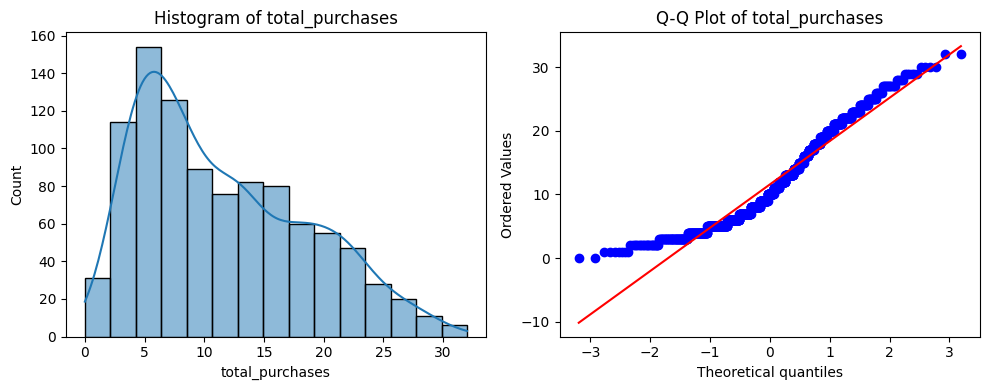

Shapiro-Wilk Test for total_purchases:
Statistic: 0.936645450247914
P-value: 5.590546913618775e-20
Sample does not look Gaussian (reject H0)
--------------------


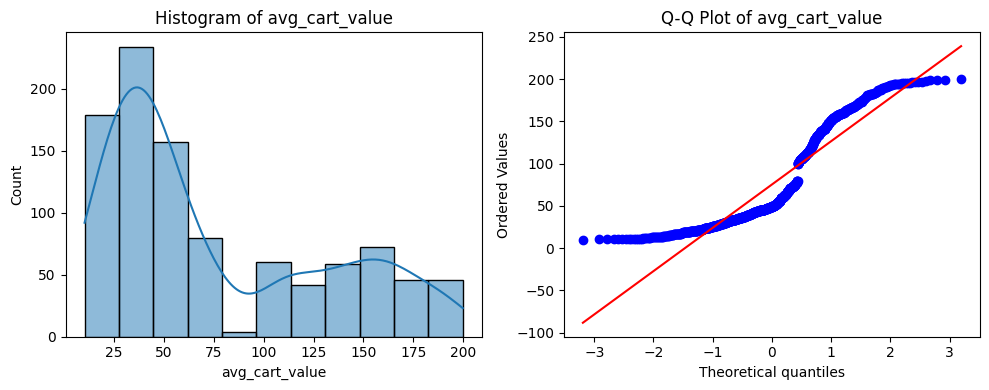

Shapiro-Wilk Test for avg_cart_value:
Statistic: 0.8618208346299174
P-value: 1.78268191729145e-28
Sample does not look Gaussian (reject H0)
--------------------


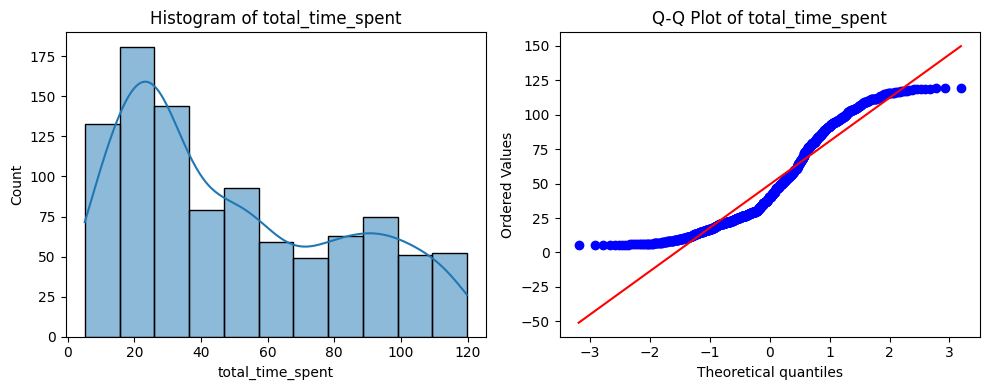

Shapiro-Wilk Test for total_time_spent:
Statistic: 0.9164788286233526
P-value: 8.310424908582083e-23
Sample does not look Gaussian (reject H0)
--------------------


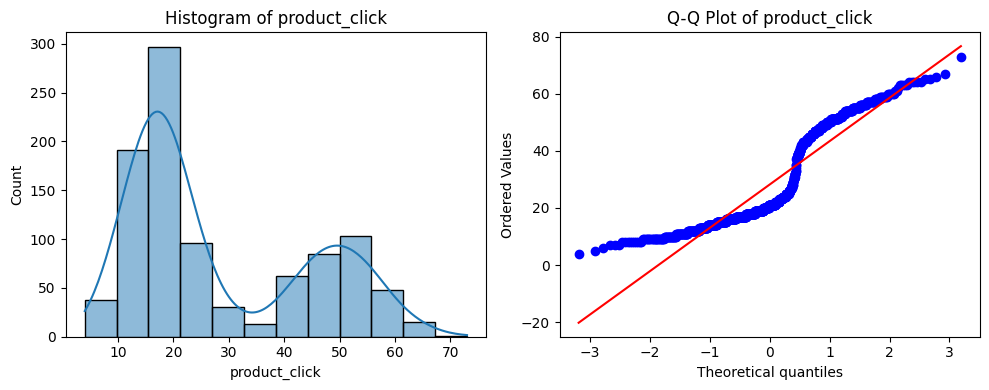

Shapiro-Wilk Test for product_click:
Statistic: 0.8621874722574205
P-value: 1.9175311800770102e-28
Sample does not look Gaussian (reject H0)
--------------------


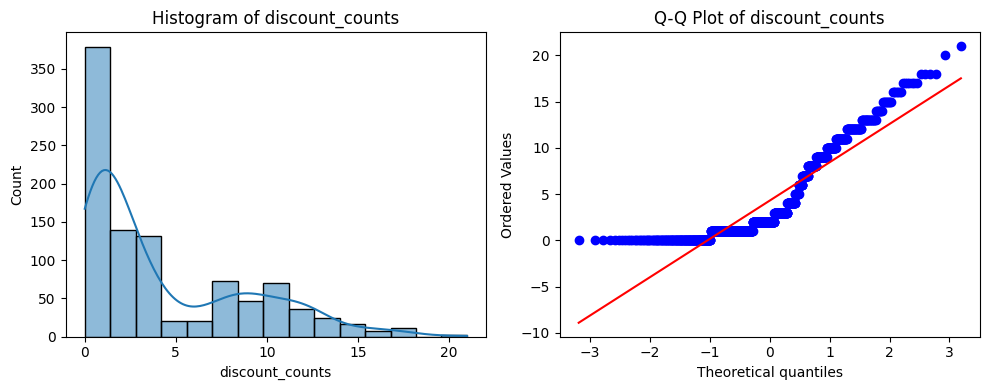

Shapiro-Wilk Test for discount_counts:
Statistic: 0.8363075379342574
P-value: 1.5595230844877117e-30
Sample does not look Gaussian (reject H0)
--------------------


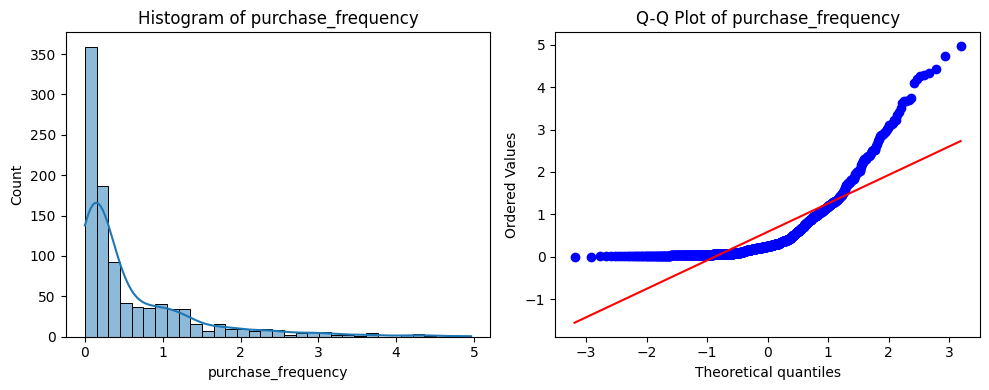

Shapiro-Wilk Test for purchase_frequency:
Statistic: 0.708364934888295
P-value: 4.062070429306343e-38
Sample does not look Gaussian (reject H0)
--------------------


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


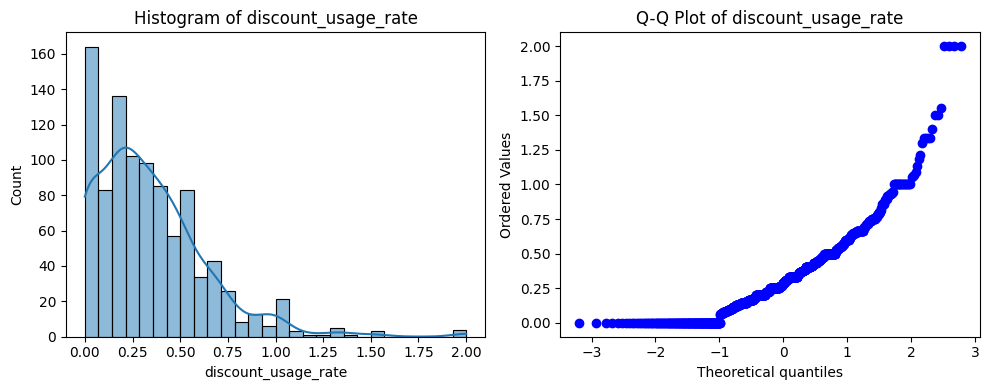

Shapiro-Wilk Test for discount_usage_rate:
Statistic: nan
P-value: 1.0
Sample looks Gaussian (fail to reject H0)
--------------------


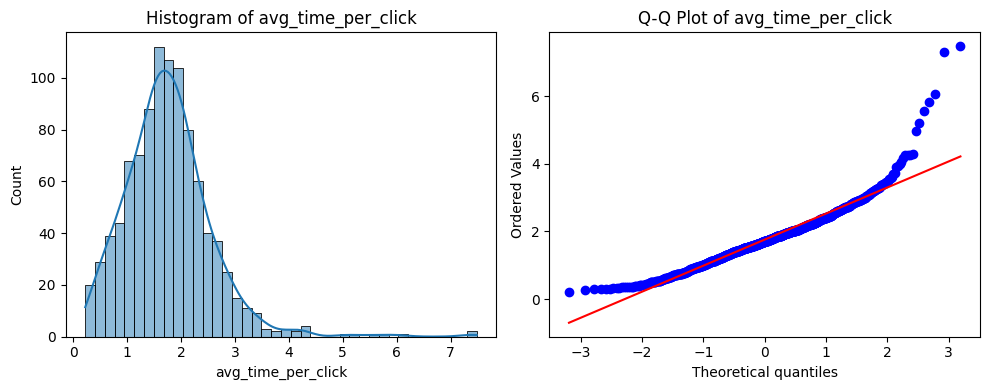

Shapiro-Wilk Test for avg_time_per_click:
Statistic: 0.9202806473171811
P-value: 2.572893757054007e-22
Sample does not look Gaussian (reject H0)
--------------------


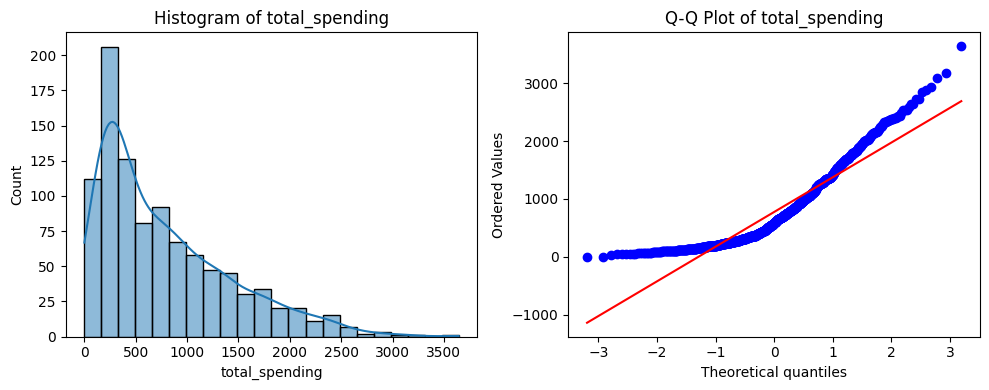

Shapiro-Wilk Test for total_spending:
Statistic: 0.8834570047074237
P-value: 1.7506909698133842e-26
Sample does not look Gaussian (reject H0)
--------------------


In [324]:


# Check for normality using histograms and Q-Q plots
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):  # Check if column is numeric
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        from scipy import stats
        stats.probplot(df[col], dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {col}')

        plt.tight_layout()
        plt.show()

        # Shapiro-Wilk test for normality
        from scipy.stats import shapiro
        statistic, p_value = shapiro(df[col])
        print(f"Shapiro-Wilk Test for {col}:")
        print(f"Statistic: {statistic}")
        print(f"P-value: {p_value}")
        alpha = 0.05  # Significance level
        if p_value > alpha:
            print("Sample looks Gaussian (fail to reject H0)")
        else:
            print("Sample does not look Gaussian (reject H0)")
        print("-" * 20)


## Handle outliers using IQR

In [325]:
# CHECK OUTLIRES USING IQR AND IF THERE ANY HANDLE THOSE THING

def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the function to each relevant column
for column in ['total_purchases', 'total_time_spent', 'discount_counts', 'product_click', 'avg_cart_value', 'purchase_frequency', 'discount_usage_rate', 'avg_time_per_click', 'total_spending']:
    df = handle_outliers_iqr(df, column)


In [326]:
df.shape

(946, 9)

In [327]:
# Apply IQR outlier removal to all numerical columns
numerical_features = ['total_purchases','avg_cart_value','total_time_spent','product_click','discount_counts','purchase_frequency','discount_usage_rate','avg_time_per_click','total_spending']
df_cleaned = df.copy()
for feature in numerical_features:
    # The function name was incorrect. Changed 'remove_outliers_iqr' to 'handle_outliers_iqr'
    df_cleaned = handle_outliers_iqr(df_cleaned, feature)

In [328]:
df_cleaned.describe()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,purchase_frequency,discount_usage_rate,avg_time_per_click,total_spending
count,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000
mean,11.313099,76.424302,50.305485,28.657082,4.177849,0.506422,0.328683,1.762093,776.434696
std,6.803043,55.429569,32.399623,16.277039,4.484907,0.612386,0.277423,0.691379,643.901583
min,1.000000,10.260000,5.240000,5.000000,0.000000,0.009748,0.000000,0.287619,44.210000
25%,6.000000,33.350000,23.155000,16.000000,1.000000,0.068692,0.125000,1.297919,263.530000
50%,10.000000,50.150000,40.780000,21.000000,2.000000,0.240919,0.266667,1.710625,573.360000
75%,16.000000,124.305000,78.270000,45.500000,7.000000,0.749514,0.500000,2.163549,1123.300000
max,32.000000,199.770000,119.820000,73.000000,21.000000,2.902903,1.555556,4.283333,3642.870000


### Box plots for numerical features

### Histograms for numerical features


### Correlation matrix


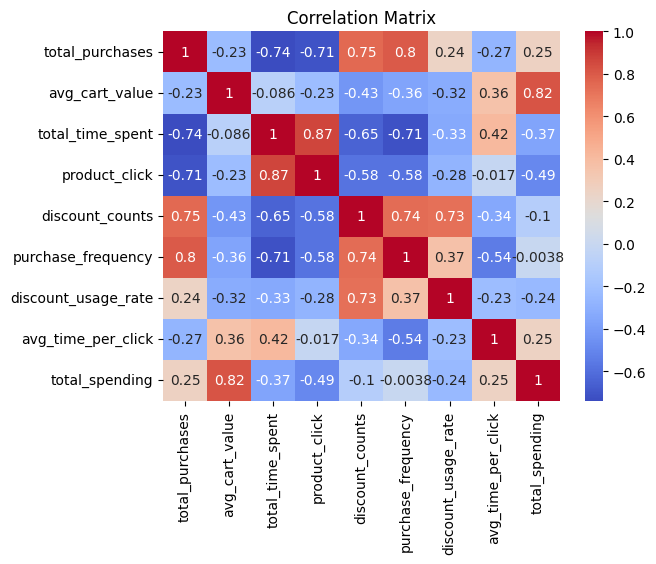

In [329]:
corr_matrix = df_cleaned[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Scaling

In [330]:

numerical_features = df_cleaned.select_dtypes(include=np.number).columns

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])



In [331]:
df_cleaned.describe()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,purchase_frequency,discount_usage_rate,avg_time_per_click,total_spending
count,9.390000e+02,9.390000e+02,939.000000,9.390000e+02,9.390000e+02,9.390000e+02,9.390000e+02,9.390000e+02,9.390000e+02
mean,8.323717e-17,-2.506574e-16,0.000000,-7.567015e-18,4.161858e-17,-1.135052e-17,-6.431963e-17,-1.253287e-16,1.409357e-16
std,1.000533e+00,1.000533e+00,1.000533,1.000533e+00,1.000533e+00,1.000533e+00,1.000533e+00,1.000533e+00,1.000533e+00
min,-1.516762e+00,-1.194300e+00,-1.391667,-1.454177e+00,-9.320316e-01,-8.114809e-01,-1.185405e+00,-2.133793e+00,-1.137775e+00
25%,-7.814048e-01,-7.775138e-01,-0.838434,-7.780179e-01,-7.089427e-01,-7.151751e-01,-7.345891e-01,-6.717318e-01,-7.969821e-01
50%,-1.931193e-01,-4.742650e-01,-0.294157,-4.706730e-01,-4.858538e-01,-4.337862e-01,-2.236647e-01,-7.448235e-02,-3.155496e-01
75%,6.893090e-01,8.642718e-01,0.863572,1.035317e+00,6.295906e-01,3.971707e-01,6.178578e-01,5.809692e-01,5.389801e-01
max,3.042451e+00,2.226455e+00,2.146678,2.725714e+00,3.752835e+00,3.915437e+00,4.424746e+00,3.648627e+00,4.454039e+00


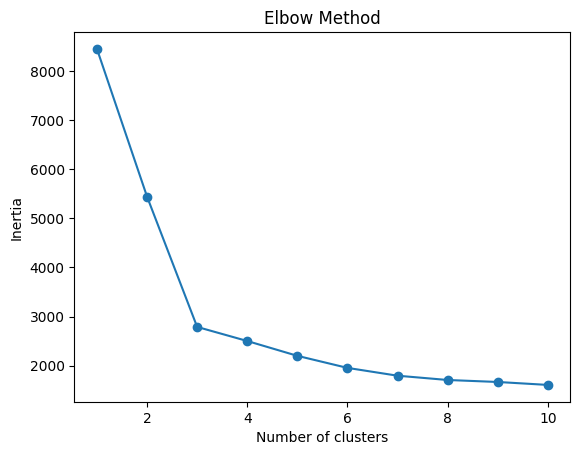

In [332]:
# Elbow Method to determine the number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cleaned)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [333]:
# Silhouette Score for optimal clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cleaned)
    score = silhouette_score(df_cleaned, kmeans.labels_)
    silhouette_scores.append(score)

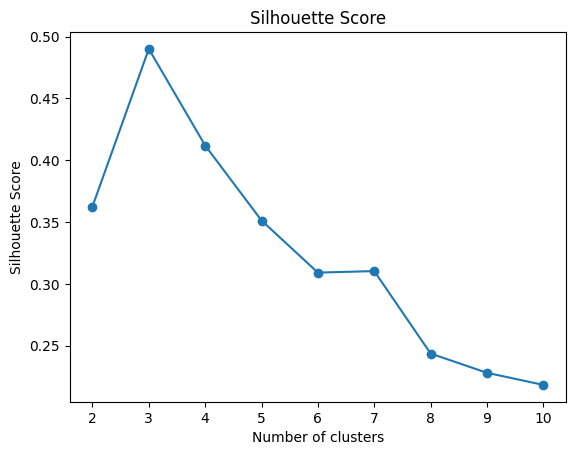

In [334]:
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Train the model

In [335]:
# K-Means clustering with optimal number of clusters
optimal_clusters = 3  # Based on elbow and silhouette score
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(df_cleaned)

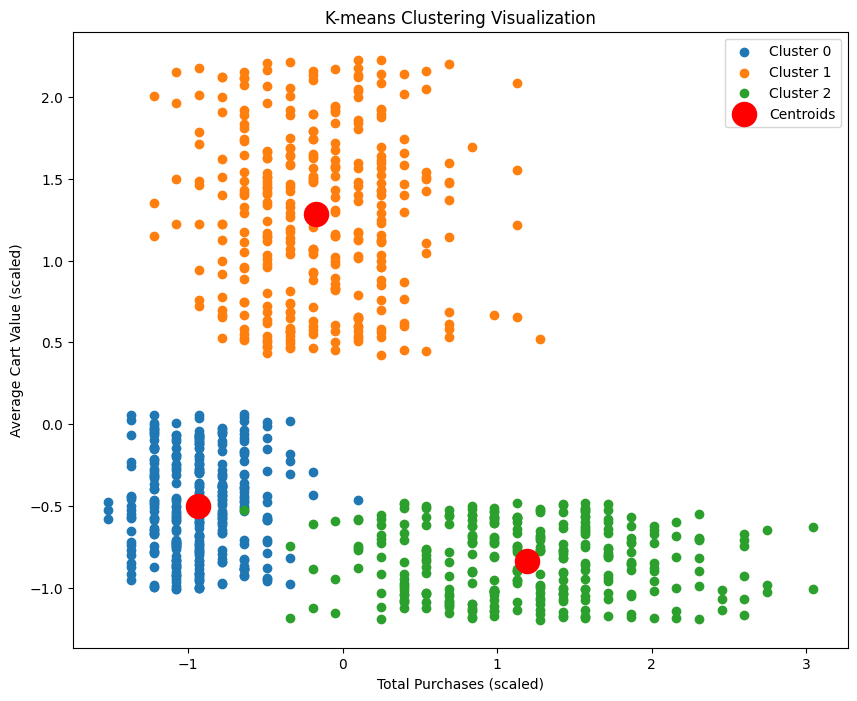

In [336]:

# Visualize the clusters
plt.figure(figsize=(10, 8))
for cluster in range(optimal_clusters):
    plt.scatter(df_cleaned[df_cleaned['cluster'] == cluster]['total_purchases'],
                df_cleaned[df_cleaned['cluster'] == cluster]['avg_cart_value'],
                label=f'Cluster {cluster}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.xlabel('Total Purchases (scaled)')
plt.ylabel('Average Cart Value (scaled)')
plt.title('K-means Clustering Visualization')
plt.legend()
plt.show()




In [337]:
# Cluster Analysis
# K-Means Cluster Characteristics
cluster_analysis = df_cleaned.groupby('cluster').agg({
    'total_purchases': 'mean',
    'avg_cart_value': 'mean',
    'total_time_spent': 'mean',
    'product_click': 'mean',
    'discount_counts': 'mean',
    'total_spending': 'mean',
    'purchase_frequency':'mean',
    'discount_usage_rate':'mean',
    'avg_time_per_click':'mean'
})
print(cluster_analysis)

         total_purchases  avg_cart_value  total_time_spent  product_click  \
cluster                                                                     
0              -0.937154       -0.497027          1.225547       1.296465   
1              -0.168684        1.283026         -0.317418      -0.526361   
2               1.193201       -0.836385         -0.984462      -0.837424   

         discount_counts  total_spending  purchase_frequency  \
cluster                                                        
0              -0.706171       -0.829311           -0.734485   
1              -0.493547        1.118208           -0.378910   
2               1.291371       -0.300907            1.199250   

         discount_usage_rate  avg_time_per_click  
cluster                                           
0                  -0.304268            0.114108  
1                  -0.417414            0.475769  
2                   0.775601           -0.632594  


In [339]:
# Labeling clusters based on characteristics
df_cleaned['segment'] = df_cleaned['cluster'].map({
    0: 'Window Shoppers',
    1: 'High Hunters',
    2: 'Bargin Hunters'
})

In [340]:
# Final cluster analysis
final_analysis = df_cleaned.groupby('segment').mean()
print(final_analysis)

                 total_purchases  avg_cart_value  total_time_spent  \
segment                                                              
Bargin Hunters          1.193201       -0.836385         -0.984462   
High Hunters           -0.168684        1.283026         -0.317418   
Window Shoppers        -0.937154       -0.497027          1.225547   

                 product_click  discount_counts  purchase_frequency  \
segment                                                               
Bargin Hunters       -0.837424         1.291371            1.199250   
High Hunters         -0.526361        -0.493547           -0.378910   
Window Shoppers       1.296465        -0.706171           -0.734485   

                 discount_usage_rate  avg_time_per_click  total_spending  \
segment                                                                    
Bargin Hunters              0.775601           -0.632594       -0.300907   
High Hunters               -0.417414            0.475769        1

In [341]:
df_cleaned.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,purchase_frequency,discount_usage_rate,avg_time_per_click,total_spending,cluster,segment
0,-0.634333,0.955156,0.057578,-0.655080,-0.932032,-0.608185,-1.185405,1.644316,0.200363,1,High Hunters
1,1.571737,-0.943037,-1.269687,-0.839487,0.629591,3.083825,-0.037874,-1.663399,-0.379879,2,Bargin Hunters
2,-1.369690,-0.798633,1.247114,1.311927,-0.485854,-0.791376,2.421120,0.074828,-1.106464,0,Window Shoppers
3,2.012951,-0.894842,-1.206999,-0.778018,1.298857,2.813030,0.257205,-1.535205,-0.163442,2,Bargin Hunters
4,-0.634333,0.884940,-0.497662,0.082548,-0.262765,-0.492900,0.360249,-0.900748,0.158051,1,High Hunters


In [342]:
#save the model

import joblib

# Assuming 'kmeans' is your trained KMeans model
joblib.dump(kmeans, 'kmeans_model.pkl')


['kmeans_model.pkl']

## predict  a new value

In [343]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib



In [344]:
# Load the trained KMeans model
model = joblib.load("kmeans_model.pkl")



In [345]:
# Example new data (replace this with your actual new data)
new_data = pd.DataFrame({
    'total_purchases': [10, 5, 20],
    'avg_cart_value': [50, 100, 30],
    'total_time_spent': [60, 30, 90],
    'product_click': [25, 15, 40],
    'discount_counts': [5, 2, 10]
})



In [346]:
# Feature Engineering (same as during training)
new_data['purchase_frequency'] = new_data['total_purchases'] / new_data['total_time_spent']
new_data['discount_usage_rate'] = new_data['discount_counts'] / new_data['total_purchases']
new_data['avg_time_per_click'] = new_data['total_time_spent'] / new_data['product_click']
new_data['total_spending'] = new_data['total_purchases'] * new_data['avg_cart_value']





In [347]:
# Scale the new data (using the same scaler)
scaler = StandardScaler()  # Replace this with the loaded scaler if available
scaled_new_data = scaler.fit_transform(new_data)  # Use transform() if scaler is pre-fitted



In [348]:
# Predict the cluster for the new data
predicted_clusters = model.predict(scaled_new_data)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [349]:
# Add the predicted clusters to the new data
new_data['cluster'] = predicted_clusters



In [352]:
# Map cluster numbers to segment names (if applicable)
cluster_to_segment = {
    0: 'Window Shoppers',
    1: 'High Hunters',
    2: 'Bargin Hunters'
}
new_data['segment'] = new_data['cluster'].map(cluster_to_segment)

# Display the results
new_data

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,purchase_frequency,discount_usage_rate,avg_time_per_click,total_spending,cluster,segment
0,10,50,60,25,5,0.166667,0.5,2.40,500,0,Window Shoppers
1,5,100,30,15,2,0.166667,0.4,2.00,500,1,High Hunters
2,20,30,90,40,10,0.222222,0.5,2.25,600,2,Bargin Hunters
